In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, average_precision_score, precision_score


In [5]:
# Load and preprocess data
outcomes = pd.read_csv('outcomes.csv')
projects = pd.read_csv('projects.csv')

outcomes['fully_funded'] = outcomes['fully_funded'].map({'t': 1, 'f': 0})
outcomes['not_fully_funded'] = 1 - outcomes['fully_funded']
projects['date_posted'] = pd.to_datetime(projects['date_posted'])
data = pd.merge(projects, outcomes[['projectid', 'not_fully_funded']], on='projectid')

data = data[data['date_posted'] >= '2010-01-01']  # Only use data after 2010
data_chicago = data[data['school_state'] == 'IL']  # Only look at the state IL
data_chicago_dropped = data_chicago.drop(columns=[
    'secondary_focus_subject', 'secondary_focus_area', 'school_metro',
    'school_ncesid', 'school_latitude', 'school_longitude'
])

# Create feature list and split data
features = [
    'primary_focus_subject', 'resource_type', 'school_nlns', 'school_charter',
    'school_county', 'school_district', 'teacher_prefix', 'poverty_level',
    'grade_level', 'fulfillment_labor_materials',
    'total_price_excluding_optional_support', 'total_price_including_optional_support'
]

X = data_chicago_dropped[features]
y = data_chicago_dropped['not_fully_funded']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define preprocessing
numeric_features = [
    'fulfillment_labor_materials',
    'total_price_excluding_optional_support',
    'total_price_including_optional_support'
]

categorical_features = [
    'primary_focus_subject', 'resource_type', 'school_nlns', 'school_charter',
    'school_county', 'school_district', 'teacher_prefix', 'poverty_level', 'grade_level'
]

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
])


=============================================================================
# STEP 1: BASELINE PERFORMANCE WITH DEFAULT HYPERPARAMETERS (WITH TOP 10% PRECISION)
=============================================================================

In [15]:
from sklearn.model_selection import cross_val_predict
from sklearn.base import clone

In [16]:
# Define models without parameter grids (defaults only)
baseline_models = [
    ('Random Forest', RandomForestClassifier(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('Decision Tree', DecisionTreeClassifier(random_state=42)),
    ('Logistic Regression', LogisticRegression(random_state=42, max_iter=1000))
]

In [17]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
baseline_results = []

In [18]:
for name, estimator in baseline_models:
    print(f"\n{'='*40}\nEvaluating {name} Baseline...\n{'='*40}")

    # Create pipeline with default estimator
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clone(estimator))  # Clone to avoid parameter leakage
    ])

    # Get predicted probabilities using cross-validation
    y_proba = cross_val_predict(
        estimator=pipeline,
        X=X_train,
        y=y_train,
        cv=cv,
        method='predict_proba',
        n_jobs=-1,
        verbose=1
    )[:, 1]  # Get probabilities for class 1

    # Calculate metrics using out-of-fold predictions
    results_df = pd.DataFrame({'score': y_proba, 'true_label': y_train.reset_index(drop=True)})
    results_df['rank'] = results_df['score'].rank(method='first', ascending=False)
    top_10_percent_cutoff = int(len(results_df) * 0.1)
    results_df['prediction'] = (results_df['rank'] <= top_10_percent_cutoff).astype(int)

    # Calculate precision@top10%
    precision_top10 = precision_score(
        results_df['true_label'],
        results_df['prediction'],
        zero_division=0
    )

    # Store results
    baseline_results.append({
        'Model': name,
        'ROC AUC (CV)': roc_auc_score(y_train, y_proba),
        'PR AUC (CV)': average_precision_score(y_train, y_proba),
        'Precision@Top10% (CV)': precision_top10
    })

# Display baseline results
print("\n\n" + "="*40 + "\nBaseline Model Performance (Cross-Validated)\n" + "="*40)
baseline_df = pd.DataFrame(baseline_results)
print(baseline_df.to_string(index=False))



Evaluating Random Forest Baseline...


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   55.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Evaluating KNN Baseline...


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   10.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Evaluating Decision Tree Baseline...


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.



Evaluating Logistic Regression Baseline...


Baseline Model Performance (Cross-Validated)
              Model  ROC AUC (CV)  PR AUC (CV)  Precision@Top10% (CV)
      Random Forest      0.707357     0.420031               0.507366
                KNN      0.634719     0.338714               0.430171
      Decision Tree      0.570947     0.290138               0.362994
Logistic Regression      0.688718     0.414557               0.496759


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.1s finished


In [13]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, auc, roc_curve, roc_auc_score
import seaborn as sns

## **Findings: Precision@Top10% was the highest with Random Forest(0.507366) but Logistic Regression was a clost with (0.496759)**

Now lets see if HYPERPARAMETER TUNING can help us.


=============================================================================
STEP 2: HYPERPARAMETER TUNING WITH GRIDSEARCH (ONLY FOR TOP MODELS)
=============================================================================

In [7]:
models = [
    {
        'name': 'Random Forest',
        'estimator': RandomForestClassifier(random_state=42),
        'param_grid': {
            'classifier__n_estimators': [50, 100, 150],
            'classifier__max_depth': [5, 10, 15],
            'classifier__min_samples_split': [2, 5, 10],
            'classifier__min_samples_leaf': [1, 2],
            'classifier__class_weight': ['balanced'],
            'classifier__bootstrap': [True]
        }
    },
    {
        'name': 'Logistic Regression',
        'estimator': LogisticRegression(random_state=42, max_iter=1000),
        'param_grid': {
            'classifier__C': [0.05,0.1, 1, 10],
            'classifier__solver': ['saga'],
            'classifier__penalty': ['l1','l2', 'none'],
            'classifier__class_weight': [None, 'balanced']
        }
    }
]

# Train and evaluate tuned models
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = []

for model in models:
    print(f"\n{'='*40}\nTraining {model['name']}...\n{'='*40}")

    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model['estimator'])
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=model['param_grid'],
        cv=cv,
        refit='PR_AUC',
        n_jobs=-1,
        verbose=1,
        scoring={
            'accuracy': 'accuracy',
            'precision': 'precision',
            'recall': 'recall',
            'f1': 'f1',
            'roc_auc': 'roc_auc',
            'PR_AUC': 'average_precision'
        }
    )

    grid_search.fit(X_train, y_train)

    # Get predictions on test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    y_proba = best_model.predict_proba(X_test)[:, 1]

    # Calculate metrics (including top 10% precision)
    report = classification_report(y_test, y_pred, output_dict=True)
    results_df = pd.DataFrame({'score': y_proba, 'true_label': y_test.reset_index(drop=True)})
    results_df['rank'] = results_df['score'].rank(method='first', ascending=False)
    top_10_percent_cutoff = int(len(results_df) * 0.1)
    results_df['prediction'] = (results_df['rank'] <= top_10_percent_cutoff).astype(int)

    results.append({
        'Model': model['name'],
        'Best Params': grid_search.best_params_,
        'Test Accuracy': report['accuracy'],
        'Test Precision (Class 1)': report['1']['precision'],
        'Test Recall (Class 1)': report['1']['recall'],
        'Test F1 (Class 1)': report['1']['f1-score'],
        'Test ROC AUC': roc_auc_score(y_test, y_proba),
        'Test PR AUC': average_precision_score(y_test, y_proba),
        'Test Precision Top10%': precision_score(results_df['true_label'], results_df['prediction'])
    })

# Display final results
print("\n\n" + "="*40 + "\nFinal Model Comparison (Tuned)\n" + "="*40)
results_df = pd.DataFrame(results)
print("\nMetrics Comparison:")
print(results_df.drop(columns='Best Params').to_string(index=False))
print("\n\n" + "="*40 + "\nBest Parameters\n" + "="*40)
for model_result in results:
    print(f"\n{model_result['Model']}:")
    print(pd.Series(model_result['Best Params']).to_string())


Training Random Forest...
Fitting 5 folds for each of 54 candidates, totalling 270 fits

Training Logistic Regression...
Fitting 5 folds for each of 24 candidates, totalling 120 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
40 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
21 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **l



Final Model Comparison (Tuned)

Metrics Comparison:
              Model  Test Accuracy  Test Precision (Class 1)  Test Recall (Class 1)  Test F1 (Class 1)  Test ROC AUC  Test PR AUC  Test Precision Top10%
      Random Forest       0.663210                  0.401724               0.643054           0.494517      0.714277     0.459238               0.556604
Logistic Regression       0.658025                  0.393443               0.618215           0.480859      0.702084     0.447423               0.530660


Best Parameters

Random Forest:
classifier__bootstrap                True
classifier__class_weight         balanced
classifier__max_depth                  15
classifier__min_samples_leaf            1
classifier__min_samples_split           5
classifier__n_estimators              100

Logistic Regression:
classifier__C                      1
classifier__class_weight    balanced
classifier__penalty               l1
classifier__solver              saga


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


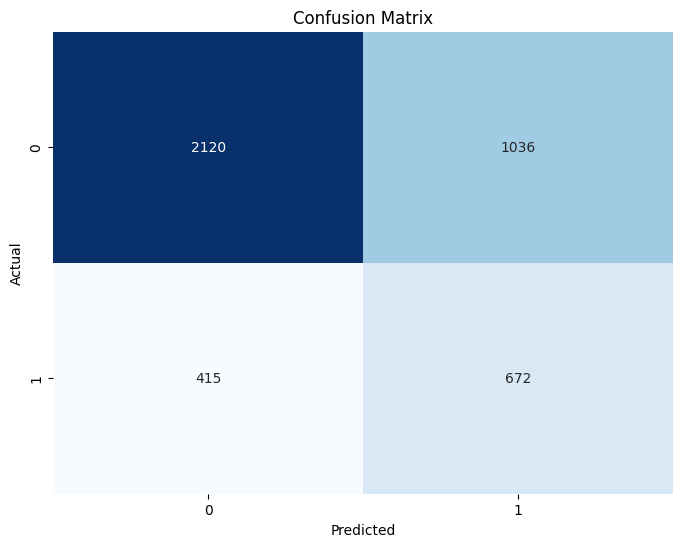

In [19]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')